https://www.kaggle.com/code/ybifoundation/multiple-linear-regression/

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2024-11-14 21:48:46.470146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 21:48:46.480838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731599326.493904   24106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731599326.497484   24106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 21:48:46.510946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
df = pd.read_csv("https://github.com/YBIFoundation/Dataset/raw/main/Boston.csv")

## Explaining the dataset and the problem

# Boston House Prices
Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1):
1. CRIM: per capita crime rate by town
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS: proportion of non-retail business acres per town
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX: nitric oxides concentration (parts per 10 million) - for some reason NX in the dataset
6. RM: average number of rooms per dwelling
7. AGE: proportion of owner-occupied units built prior to 1940
8. DIS: weighted distances to ﬁve Boston employment centers
9. RAD: index of accessibility to radial highways
10. TAX: full-value property-tax rate per \\$10,000
11. PTRATIO: pupil-teacher ratio by town
12. B: 1000(Bk−0.63)2 where Bk is the proportion of blacks by town
13. LSTAT: % lower status of the population
14. MEDV: Median value of owner-occupied homes in $1000s

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Descriptive analytics

In [4]:
NUMERICAL_COLUMNS = ['CRIM', 'ZN', 'INDUS', 'NX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df[NUMERICAL_COLUMNS].describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
NX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000
PTRATIO,506.0,18.455534,2.164946,12.60000,17.400000,19.05000,20.200000,22.0000
B,506.0,356.674032,91.294864,0.32000,375.377500,391.44000,396.225000,396.9000


In [5]:
CATEGORICAL_COLUMNS = ['CHAS', ]
df[CATEGORICAL_COLUMNS].describe().T

,count,mean,std,min,25%,50%,75%,max
CHAS,506.0,0.06917,0.253994,0.0,0.0,0.0,0.0,1.0


In [6]:
ORDINAL_COLUMNS = ['RAD', ]
df[ORDINAL_COLUMNS].describe().T

,count,mean,std,min,25%,50%,75%,max
RAD,506.0,9.549407,8.707259,1.0,4.0,5.0,24.0,24.0


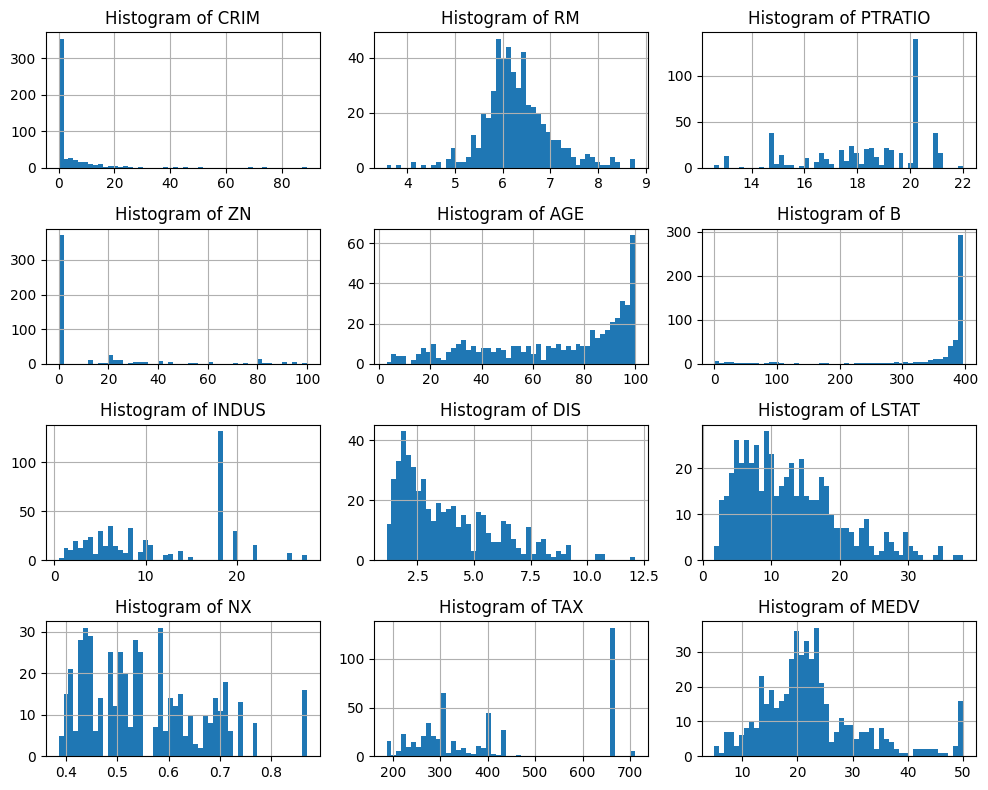

In [7]:
# Histograms of Numerical Columns
fig, axes = plt.subplots(4, 3, figsize=(10, 8))

i = 0
j = 0
for col in NUMERICAL_COLUMNS:
    df[col].hist(bins = 50, ax = axes[i, j])
    axes[i, j].set_title("Histogram of " + col)
    if i >= 3: j += 1
    i = (i + 1) % 4
fig.tight_layout()
plt.show()

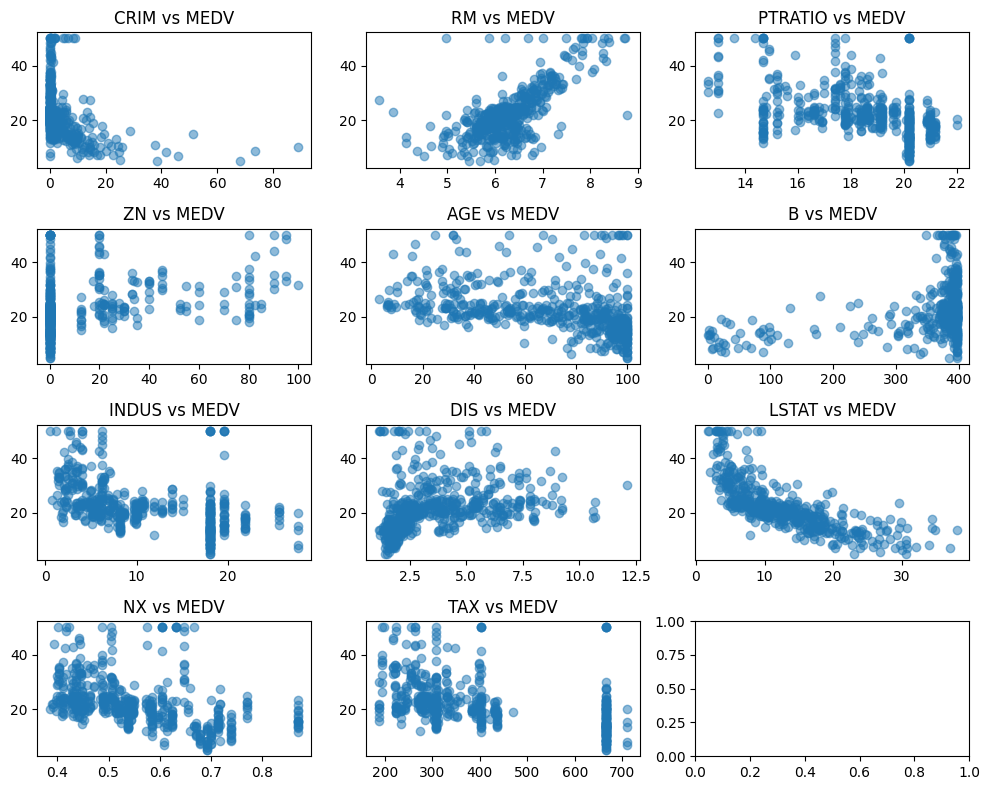

In [8]:
# MEDV vs. Numerical Columns
fig, axes = plt.subplots(4, 3, figsize=(10, 8))

i = 0
j = 0
for col in NUMERICAL_COLUMNS:
    if col == "MEDV": continue
    axes[i, j].scatter(df[col], df['MEDV'], alpha=0.5)
    axes[i, j].set_title(col + " vs MEDV")
    i += 1
    if i >= 4:
        j += 1
        i = 0
fig.tight_layout()
plt.show()

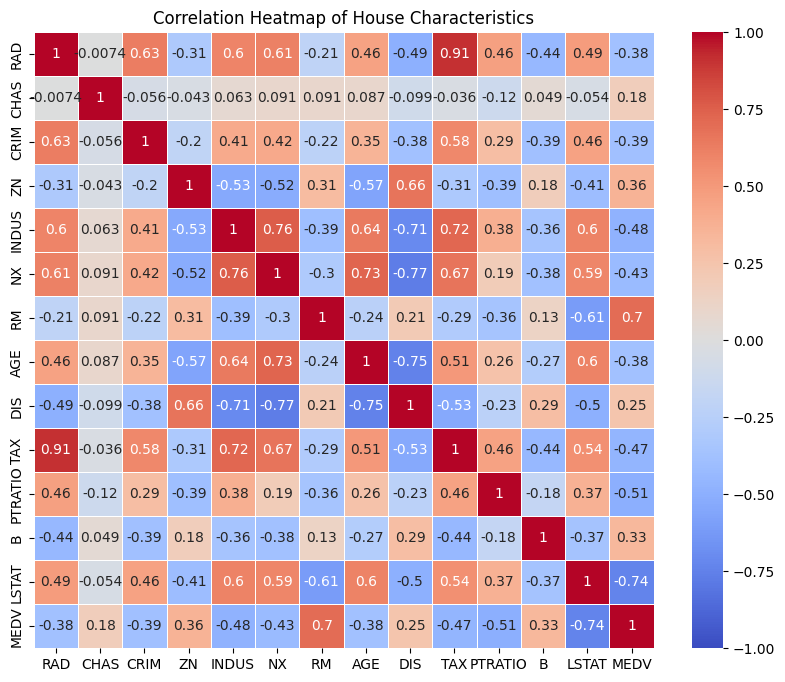

In [9]:
# create a heatmap
features = df[[*ORDINAL_COLUMNS, *CATEGORICAL_COLUMNS, *NUMERICAL_COLUMNS]].dropna().apply(pd.to_numeric, errors='coerce')

correlation_matrix = features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, vmin = -1, vmax =1)
plt.title('Correlation Heatmap of House Characteristics')
plt.show()

## Checking for missing values

In [10]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NX         0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Outlier detection
No significant outliers detected.

In [11]:
outliers = pd.DataFrame()
for column in NUMERICAL_COLUMNS:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

outliers = df.dropna()
outliers

,CRIM,ZN,INDUS,CHAS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


## EDA -- feature engineering -- One hot encoding -- PCA

In [12]:
numerical_data = df[NUMERICAL_COLUMNS]
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numerical_data.to_numpy())
df[NUMERICAL_COLUMNS] = normalizer(numerical_data)
df

2024-11-14 21:48:51.339421: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


,CRIM,ZN,INDUS,CHAS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419782,0.284830,-1.287910,0,-0.144218,0.413671,-0.120013,0.140214,1,-0.666608,-1.459001,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,0,-0.740262,0.194274,0.367167,0.557160,2,-0.987329,-0.303095,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,0,-0.740262,1.282713,-0.265812,0.557160,2,-0.987329,-0.303095,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,0,-0.835284,1.016302,-0.809888,1.077737,3,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,0,-0.835284,1.228576,-0.511180,1.077737,3,-1.106115,0.113032,0.441052,-1.026501,1.487503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.115738,0,0.158124,0.439315,0.018673,-0.625796,1,-0.803212,1.176466,0.387217,-0.418147,-0.014454
502,-0.415249,-0.487722,0.115738,0,0.158124,-0.234548,0.288933,-0.716639,1,-0.803212,1.176466,0.441052,-0.500850,-0.210362
503,-0.413447,-0.487722,0.115738,0,0.158124,0.984959,0.797449,-0.773684,1,-0.803212,1.176466,0.441052,-0.983048,0.148802
504,-0.407764,-0.487722,0.115738,0,0.158124,0.725672,0.736997,-0.668437,1,-0.803212,1.176466,0.403225,-0.865302,-0.057989


In [13]:
if 'CHAS' in df.columns:
    df = pd.get_dummies(df, columns=CATEGORICAL_COLUMNS)
df

,CRIM,ZN,INDUS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CHAS_0,CHAS_1
0,-0.419782,0.284830,-1.287910,-0.144218,0.413671,-0.120013,0.140214,1,-0.666608,-1.459001,0.441052,-1.075562,0.159686,True,False
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367167,0.557160,2,-0.987329,-0.303095,0.441052,-0.492439,-0.101524,True,False
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282713,-0.265812,0.557160,2,-0.987329,-0.303095,0.396427,-1.208727,1.324247,True,False
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016302,-0.809888,1.077737,3,-1.106115,0.113032,0.416163,-1.361517,1.182758,True,False
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228576,-0.511180,1.077737,3,-1.106115,0.113032,0.441052,-1.026501,1.487503,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.115738,0.158124,0.439315,0.018673,-0.625796,1,-0.803212,1.176466,0.387217,-0.418147,-0.014454,True,False
502,-0.415249,-0.487722,0.115738,0.158124,-0.234548,0.288933,-0.716639,1,-0.803212,1.176466,0.441052,-0.500850,-0.210362,True,False
503,-0.413447,-0.487722,0.115738,0.158124,0.984959,0.797449,-0.773684,1,-0.803212,1.176466,0.441052,-0.983048,0.148802,True,False
504,-0.407764,-0.487722,0.115738,0.158124,0.725672,0.736997,-0.668437,1,-0.803212,1.176466,0.403225,-0.865302,-0.057989,True,False


In [14]:
scaler = StandardScaler()
df['RAD'] = scaler.fit_transform(df[['RAD']])

In [15]:
Y = df.pop("MEDV")
X = df
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Fitting the model and tuning the model's parameters and hyperparameters
### Hyperparameters Tuning
### Regularization

In [16]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
NX         0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
CHAS_0     0
CHAS_1     0
dtype: int64

In [17]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(1, input_dim=X_train.shape[1], activation='linear')
    ]
)

/home/student/code/ml_ds/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

In [19]:
%%time
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9509 - mae: 1.0648 - val_loss: 1.2616 - val_mae: 0.8361
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4686 - mae: 0.9194 - val_loss: 0.9521 - val_mae: 0.7574
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0672 - mae: 0.7887 - val_loss: 0.7084 - val_mae: 0.6673
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7138 - mae: 0.6643 - val_loss: 0.5685 - val_mae: 0.5843
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6124 - mae: 0.5917 - val_loss: 0.4926 - val_mae: 0.5345
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5219 - mae: 0.5454 - val_loss: 0.4527 - val_mae: 0.5098
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4888 - mae: 0.5177 - val_loss: 0.4550 - val_mae: 0.5086
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4431 - mae: 0.5166 - val_loss: 0.4225 - val_mae: 0.4844
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.39

## Model metrics and validation

In [23]:
loss, mae = model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2261 - mae: 0.3160 


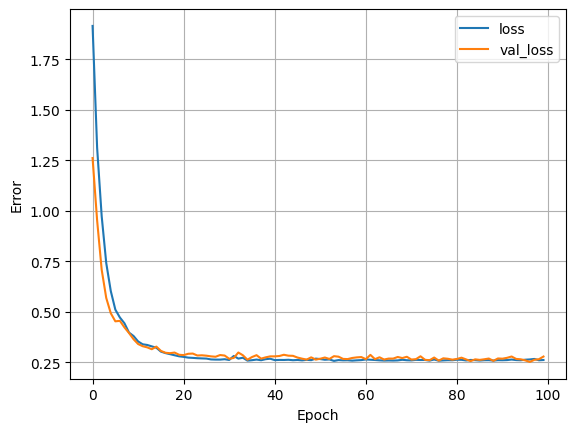

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

## Dealing with overfitting or underfitting

## Model Drift